## Setup and Imports

In [3]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


---
# Task 1: DenseNet-121 for CIFAR-10 Classification

### Objectives:
- Load pretrained DenseNet-121 model
- Freeze all convolutional layers
- Replace the final classifier layer
- Train only the classifier
- Evaluate performance on validation dataset

## 1.1 Load and Preprocess CIFAR-10 Dataset

In [4]:
# Data augmentation and normalization for CIFAR-10
# ImageNet normalization values (since we're using pretrained DenseNet)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform
)

# Split training data into train and validation sets (80-20 split)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s] 


Training samples: 40000
Validation samples: 10000
Test samples: 10000


## 1.2 Load Pretrained DenseNet-121 and Modify Architecture

In [5]:
# Load pretrained DenseNet-121
model_densenet = models.densenet121(pretrained=True)

# Freeze all convolutional layers (feature extraction layers)
for param in model_densenet.features.parameters():
    param.requires_grad = False

# Get the number of input features to the classifier
num_features = model_densenet.classifier.in_features

# Replace the classifier with a new one for CIFAR-10 (10 classes)
# Adding BatchNorm for better stability
model_densenet.classifier = nn.Sequential(
    nn.BatchNorm1d(num_features),
    nn.Dropout(0.3),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.3),
    nn.Linear(512, 10)
)

# Move model to device
model_densenet = model_densenet.to(device)

# Print model summary
print("\nDenseNet-121 Model Architecture (Modified):")
print(f"Total parameters: {sum(p.numel() for p in model_densenet.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_densenet.parameters() if p.requires_grad):,}")
print(f"Frozen parameters: {sum(p.numel() for p in model_densenet.parameters() if not p.requires_grad):,}")

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\anshu/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 34.3MB/s]



DenseNet-121 Model Architecture (Modified):
Total parameters: 7,486,858
Trainable parameters: 533,002
Frozen parameters: 6,953,856


## 1.3 Training Configuration and Functions

In [7]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_densenet = optim.Adam(model_densenet.classifier.parameters(), lr=0.001)

# Learning rate scheduler
scheduler_densenet = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_densenet, mode='min', factor=0.5, patience=3
)

# Early stopping configuration
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

## 1.4 Train DenseNet-121 on CIFAR-10

In [8]:
# Training loop
num_epochs = 30
early_stopping = EarlyStopping(patience=7)

train_losses_densenet = []
val_losses_densenet = []
train_accs_densenet = []
val_accs_densenet = []

print("Training DenseNet-121 on CIFAR-10...\n")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss, train_acc = train_epoch(model_densenet, train_loader, criterion, optimizer_densenet, device)
    train_losses_densenet.append(train_loss)
    train_accs_densenet.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model_densenet, val_loader, criterion, device)
    val_losses_densenet.append(val_loss)
    val_accs_densenet.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%\n")
    
    # Learning rate scheduling
    scheduler_densenet.step(val_loss)
    
    # Early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

print("Training completed!")

Training DenseNet-121 on CIFAR-10...

Epoch 1/30


Train Loss: 1.5268 | Train Acc: 45.84%
Val Loss: 1.3322 | Val Acc: 51.73%

Epoch 2/30


Train Loss: 1.3991 | Train Acc: 49.89%
Val Loss: 1.2716 | Val Acc: 55.03%

Epoch 3/30


Train Loss: 1.3604 | Train Acc: 51.24%
Val Loss: 1.2674 | Val Acc: 54.21%

Epoch 4/30


Train Loss: 1.3396 | Train Acc: 52.03%
Val Loss: 1.2378 | Val Acc: 56.13%

Epoch 5/30


Train Loss: 1.3234 | Train Acc: 52.52%
Val Loss: 1.2073 | Val Acc: 56.97%

Epoch 6/30


Train Loss: 1.3109 | Train Acc: 53.10%
Val Loss: 1.2014 | Val Acc: 57.49%

Epoch 7/30


Train Loss: 1.2972 | Train Acc: 53.62%
Val Loss: 1.2000 | Val Acc: 56.96%

Epoch 8/30


Train Loss: 1.2856 | Train Acc: 54.03%
Val Loss: 1.1877 | Val Acc: 58.64%

Epoch 9/30


Train Loss: 1.2739 | Train Acc: 54.53%
Val Loss: 1.1672 | Val Acc: 58.68%

Epoch 10/30


Train Loss: 1.2704 | Train Acc: 54.72%
Val Loss: 1.1692 | Val Acc: 58.55%

Epoch 11/30


Train Loss: 1.2672 | Train Acc: 54.84%
Val Loss: 1.1620 | Val Acc: 58.46%

Epoch 12/30


Train Loss: 1.2549 | Train Acc: 55.27%
Val Loss: 1.1629 | Val Acc: 58.68%

Epoch 13/30


Train Loss: 1.2464 | Train Acc: 55.35%
Val Loss: 1.1463 | Val Acc: 59.93%

Epoch 14/30


Train Loss: 1.2404 | Train Acc: 55.67%
Val Loss: 1.1633 | Val Acc: 58.74%

Epoch 15/30


Train Loss: 1.2402 | Train Acc: 55.74%
Val Loss: 1.1468 | Val Acc: 59.14%

Epoch 16/30


Train Loss: 1.2300 | Train Acc: 56.00%
Val Loss: 1.1254 | Val Acc: 60.53%

Epoch 17/30


Train Loss: 1.2254 | Train Acc: 56.33%
Val Loss: 1.1401 | Val Acc: 59.76%

Epoch 18/30


Train Loss: 1.2219 | Train Acc: 56.34%
Val Loss: 1.1377 | Val Acc: 59.52%

Epoch 19/30


Train Loss: 1.2233 | Train Acc: 56.17%
Val Loss: 1.1287 | Val Acc: 60.62%

Epoch 20/30


Train Loss: 1.2157 | Train Acc: 56.81%
Val Loss: 1.1224 | Val Acc: 60.40%

Epoch 21/30


Train Loss: 1.2144 | Train Acc: 56.54%
Val Loss: 1.1190 | Val Acc: 60.17%

Epoch 22/30


Train Loss: 1.2141 | Train Acc: 56.91%
Val Loss: 1.1256 | Val Acc: 60.88%

Epoch 23/30


Train Loss: 1.2115 | Train Acc: 56.78%
Val Loss: 1.1178 | Val Acc: 60.84%

Epoch 24/30


Train Loss: 1.2032 | Train Acc: 56.90%
Val Loss: 1.1204 | Val Acc: 60.75%

Epoch 25/30


Train Loss: 1.2106 | Train Acc: 56.82%
Val Loss: 1.1065 | Val Acc: 60.74%

Epoch 26/30


Train Loss: 1.2005 | Train Acc: 57.16%
Val Loss: 1.1028 | Val Acc: 60.87%

Epoch 27/30


Train Loss: 1.2004 | Train Acc: 57.47%
Val Loss: 1.1073 | Val Acc: 60.69%

Epoch 28/30


Train Loss: 1.2038 | Train Acc: 57.15%
Val Loss: 1.1189 | Val Acc: 60.56%

Epoch 29/30


Train Loss: 1.1894 | Train Acc: 57.81%
Val Loss: 1.1043 | Val Acc: 60.71%

Epoch 30/30


Train Loss: 1.1961 | Train Acc: 57.33%
Val Loss: 1.1128 | Val Acc: 60.63%

Training completed!


## 1.5 Evaluate DenseNet-121 on Test Set

In [9]:
# Test the model
test_loss, test_acc = validate(model_densenet, test_loader, criterion, device)
print(f"\n{'='*50}")
print(f"Task 1 - DenseNet-121 Final Test Results")
print(f"{'='*50}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"{'='*50}\n")


Task 1 - DenseNet-121 Final Test Results
Test Loss: 1.0715
Test Accuracy: 62.81%



## 1.6 Plot Training Curves for DenseNet-121

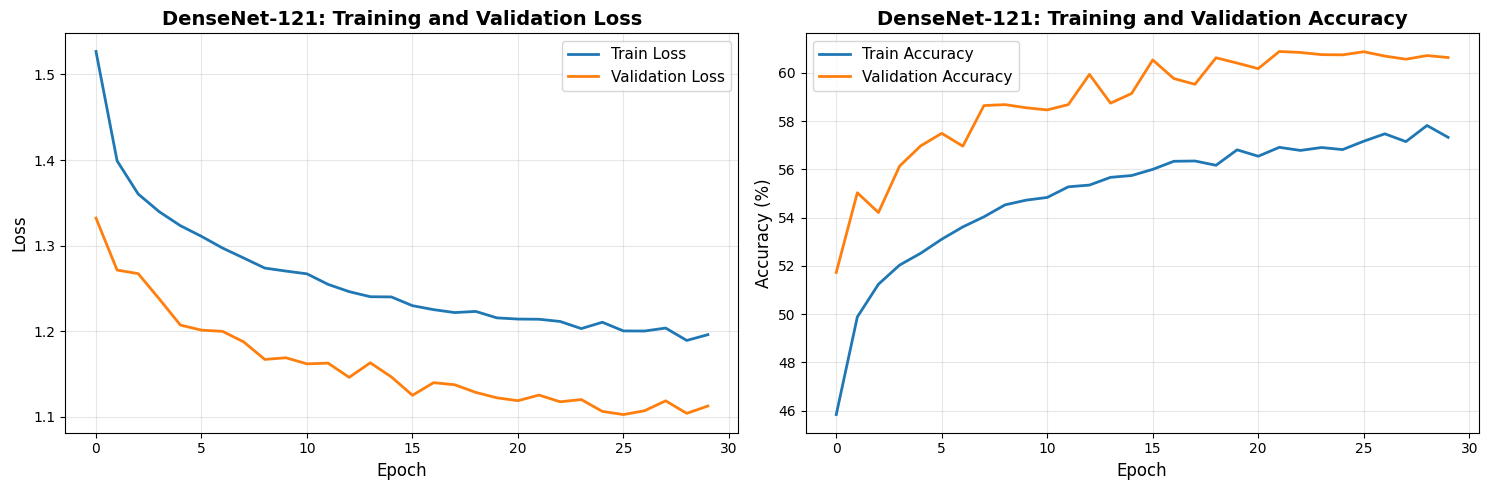

In [10]:
# Plot training and validation curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(train_losses_densenet, label='Train Loss', linewidth=2)
ax1.plot(val_losses_densenet, label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('DenseNet-121: Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(train_accs_densenet, label='Train Accuracy', linewidth=2)
ax2.plot(val_accs_densenet, label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('DenseNet-121: Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('densenet_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 1.7 Confusion Matrix for DenseNet-121

Generating predictions: 100%|██████████| 79/79 [00:16<00:00,  4.81it/s]


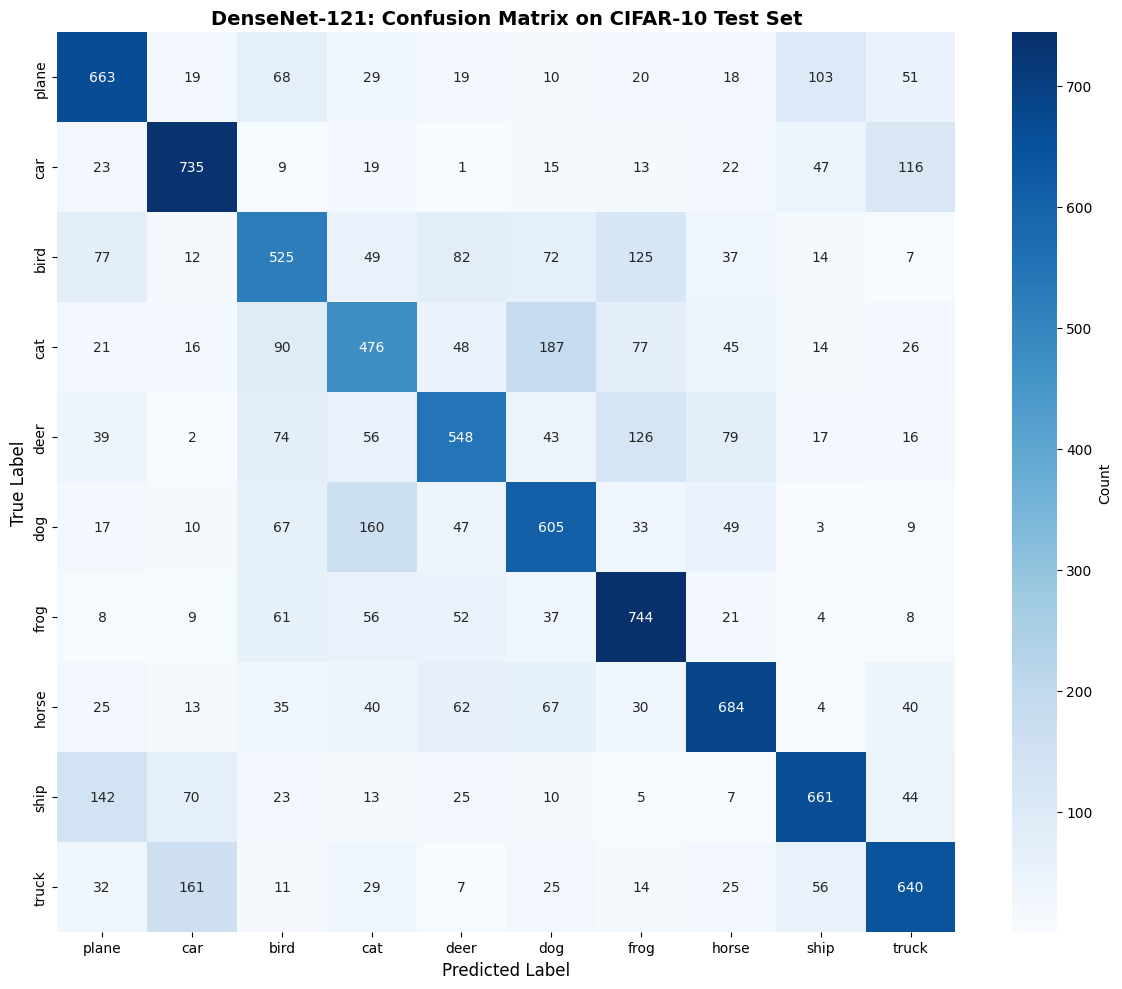


Classification Report:
              precision    recall  f1-score   support

       plane       0.63      0.66      0.65      1000
         car       0.70      0.73      0.72      1000
        bird       0.55      0.53      0.53      1000
         cat       0.51      0.48      0.49      1000
        deer       0.62      0.55      0.58      1000
         dog       0.56      0.60      0.58      1000
        frog       0.63      0.74      0.68      1000
       horse       0.69      0.68      0.69      1000
        ship       0.72      0.66      0.69      1000
       truck       0.67      0.64      0.65      1000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000



In [11]:
# Generate confusion matrix
model_densenet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Generating predictions"):
        inputs = inputs.to(device)
        outputs = model_densenet(inputs)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('DenseNet-121: Confusion Matrix on CIFAR-10 Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('densenet_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

---
# Task 2: Deep Neural Network for MNIST Classification

### Objectives:
- Load and preprocess MNIST dataset
- Flatten images
- Build multilayer neural network (no CNN)
- Train and evaluate on training and validation sets

## 2.1 Load and Preprocess MNIST Dataset

In [12]:
# Data augmentation and normalization for MNIST
mnist_train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
mnist_train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=mnist_train_transform
)

mnist_test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=mnist_test_transform
)

# Split training data into train and validation sets (80-20 split)
mnist_train_size = int(0.8 * len(mnist_train_dataset))
mnist_val_size = len(mnist_train_dataset) - mnist_train_size
mnist_train_dataset, mnist_val_dataset = random_split(
    mnist_train_dataset, [mnist_train_size, mnist_val_size]
)

print(f"MNIST Training samples: {len(mnist_train_dataset)}")
print(f"MNIST Validation samples: {len(mnist_val_dataset)}")
print(f"MNIST Test samples: {len(mnist_test_dataset)}")

# Create data loaders
mnist_batch_size = 128
mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=mnist_batch_size, shuffle=True, num_workers=2)
mnist_val_loader = DataLoader(mnist_val_dataset, batch_size=mnist_batch_size, shuffle=False, num_workers=2)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=mnist_batch_size, shuffle=False, num_workers=2)

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.92MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 107kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 858kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.36MB/s]

MNIST Training samples: 48000
MNIST Validation samples: 12000
MNIST Test samples: 10000


## 2.2 Build Deep Neural Network (No CNN)

In [13]:
# Deep Neural Network for MNIST
class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[512, 256, 128], num_classes=10, dropout_p=0.3):
        super(DeepNeuralNetwork, self).__init__()
        
        self.flatten = nn.Flatten()
        
        # Build layers dynamically
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_p))
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.network(x)
        return x

# Create model
model_dnn = DeepNeuralNetwork(
    input_size=28*28,
    hidden_sizes=[512, 256, 128],
    num_classes=10,
    dropout_p=0.3
).to(device)

# Print model summary
print("\nDeep Neural Network Architecture:")
print(model_dnn)
print(f"\nTotal parameters: {sum(p.numel() for p in model_dnn.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_dnn.parameters() if p.requires_grad):,}")


Deep Neural Network Architecture:
DeepNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=10, bias=True)
  )
)

Total parameters: 569,226
Trainable parameters: 569,226


## 2.3 Training Configuration for DNN

In [15]:
# Loss function and optimizer for DNN
criterion_dnn = nn.CrossEntropyLoss()
optimizer_dnn = optim.Adam(model_dnn.parameters(), lr=0.001)

# Learning rate scheduler
scheduler_dnn = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_dnn, mode='min', factor=0.5, patience=3
)

## 2.4 Train Deep Neural Network on MNIST

In [16]:
# Training loop for DNN
num_epochs_dnn = 30
early_stopping_dnn = EarlyStopping(patience=7)

train_losses_dnn = []
val_losses_dnn = []
train_accs_dnn = []
val_accs_dnn = []

print("Training Deep Neural Network on MNIST...\n")

for epoch in range(num_epochs_dnn):
    print(f"Epoch {epoch+1}/{num_epochs_dnn}")
    
    # Train
    train_loss, train_acc = train_epoch(model_dnn, mnist_train_loader, criterion_dnn, optimizer_dnn, device)
    train_losses_dnn.append(train_loss)
    train_accs_dnn.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model_dnn, mnist_val_loader, criterion_dnn, device)
    val_losses_dnn.append(val_loss)
    val_accs_dnn.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%\n")
    
    # Learning rate scheduling
    scheduler_dnn.step(val_loss)
    
    # Early stopping
    early_stopping_dnn(val_loss)
    if early_stopping_dnn.early_stop:
        print("Early stopping triggered!")
        break

print("Training completed!")

Training Deep Neural Network on MNIST...

Epoch 1/30


Train Loss: 0.6564 | Train Acc: 79.99%
Val Loss: 0.2541 | Val Acc: 92.13%

Epoch 2/30


Train Loss: 0.3242 | Train Acc: 89.95%
Val Loss: 0.1932 | Val Acc: 93.99%

Epoch 3/30


Train Loss: 0.2761 | Train Acc: 91.35%
Val Loss: 0.1666 | Val Acc: 94.78%

Epoch 4/30


Train Loss: 0.2417 | Train Acc: 92.56%
Val Loss: 0.1465 | Val Acc: 95.33%

Epoch 5/30


Train Loss: 0.2224 | Train Acc: 93.02%
Val Loss: 0.1336 | Val Acc: 95.93%

Epoch 6/30


Train Loss: 0.2086 | Train Acc: 93.58%
Val Loss: 0.1302 | Val Acc: 95.71%

Epoch 7/30


Train Loss: 0.1994 | Train Acc: 93.84%
Val Loss: 0.1191 | Val Acc: 96.17%

Epoch 8/30


Train Loss: 0.1848 | Train Acc: 94.27%
Val Loss: 0.1122 | Val Acc: 96.55%

Epoch 9/30


Train Loss: 0.1782 | Train Acc: 94.47%
Val Loss: 0.1073 | Val Acc: 96.62%

Epoch 10/30


Train Loss: 0.1693 | Train Acc: 94.77%
Val Loss: 0.1010 | Val Acc: 96.80%

Epoch 11/30


Train Loss: 0.1667 | Train Acc: 94.85%
Val Loss: 0.0977 | Val Acc: 96.88%

Epoch 12/30


Train Loss: 0.1546 | Train Acc: 95.31%
Val Loss: 0.0987 | Val Acc: 96.87%

Epoch 13/30


Train Loss: 0.1553 | Train Acc: 95.18%
Val Loss: 0.0888 | Val Acc: 97.09%

Epoch 14/30


Train Loss: 0.1529 | Train Acc: 95.34%
Val Loss: 0.0899 | Val Acc: 97.09%

Epoch 15/30


Train Loss: 0.1475 | Train Acc: 95.46%
Val Loss: 0.0914 | Val Acc: 97.17%

Epoch 16/30


Train Loss: 0.1418 | Train Acc: 95.65%
Val Loss: 0.0858 | Val Acc: 97.36%

Epoch 17/30


Train Loss: 0.1398 | Train Acc: 95.62%
Val Loss: 0.0880 | Val Acc: 97.13%

Epoch 18/30


Train Loss: 0.1348 | Train Acc: 95.88%
Val Loss: 0.0830 | Val Acc: 97.27%

Epoch 19/30


Train Loss: 0.1339 | Train Acc: 95.86%
Val Loss: 0.0807 | Val Acc: 97.51%

Epoch 20/30


Train Loss: 0.1315 | Train Acc: 95.98%
Val Loss: 0.0753 | Val Acc: 97.73%

Epoch 21/30


Train Loss: 0.1328 | Train Acc: 95.88%
Val Loss: 0.0789 | Val Acc: 97.39%

Epoch 22/30


Train Loss: 0.1252 | Train Acc: 96.12%
Val Loss: 0.0755 | Val Acc: 97.69%

Epoch 23/30


Train Loss: 0.1259 | Train Acc: 96.12%
Val Loss: 0.0775 | Val Acc: 97.45%

Epoch 24/30


Train Loss: 0.1226 | Train Acc: 96.22%
Val Loss: 0.0740 | Val Acc: 97.67%

Epoch 25/30


Train Loss: 0.1228 | Train Acc: 96.20%
Val Loss: 0.0715 | Val Acc: 97.63%

Epoch 26/30


Train Loss: 0.1198 | Train Acc: 96.37%
Val Loss: 0.0676 | Val Acc: 97.81%

Epoch 27/30


Train Loss: 0.1167 | Train Acc: 96.34%
Val Loss: 0.0678 | Val Acc: 97.70%

Epoch 28/30


Train Loss: 0.1162 | Train Acc: 96.36%
Val Loss: 0.0691 | Val Acc: 97.82%

Epoch 29/30


Train Loss: 0.1147 | Train Acc: 96.44%
Val Loss: 0.0669 | Val Acc: 97.73%

Epoch 30/30


Train Loss: 0.1147 | Train Acc: 96.47%
Val Loss: 0.0660 | Val Acc: 97.92%

Training completed!


## 2.5 Evaluate DNN on Test Set

In [17]:
# Test the DNN model
test_loss_dnn, test_acc_dnn = validate(model_dnn, mnist_test_loader, criterion_dnn, device)
print(f"\n{'='*50}")
print(f"Task 2 - Deep Neural Network Final Test Results")
print(f"{'='*50}")
print(f"Test Loss: {test_loss_dnn:.4f}")
print(f"Test Accuracy: {test_acc_dnn:.2f}%")
print(f"{'='*50}\n")


Task 2 - Deep Neural Network Final Test Results
Test Loss: 0.0334
Test Accuracy: 98.83%



## 2.6 Plot Training Curves for DNN

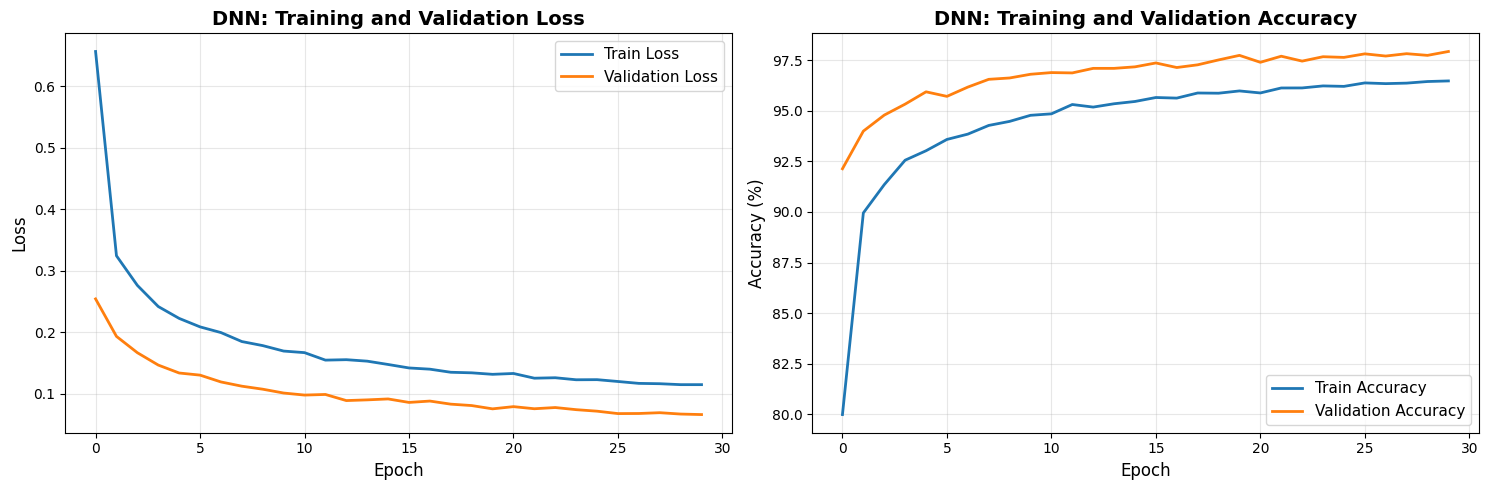

In [18]:
# Plot training and validation curves for DNN
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(train_losses_dnn, label='Train Loss', linewidth=2)
ax1.plot(val_losses_dnn, label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('DNN: Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(train_accs_dnn, label='Train Accuracy', linewidth=2)
ax2.plot(val_accs_dnn, label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('DNN: Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dnn_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.7 Confusion Matrix for DNN

Generating predictions: 100%|██████████| 79/79 [00:07<00:00, 10.05it/s]


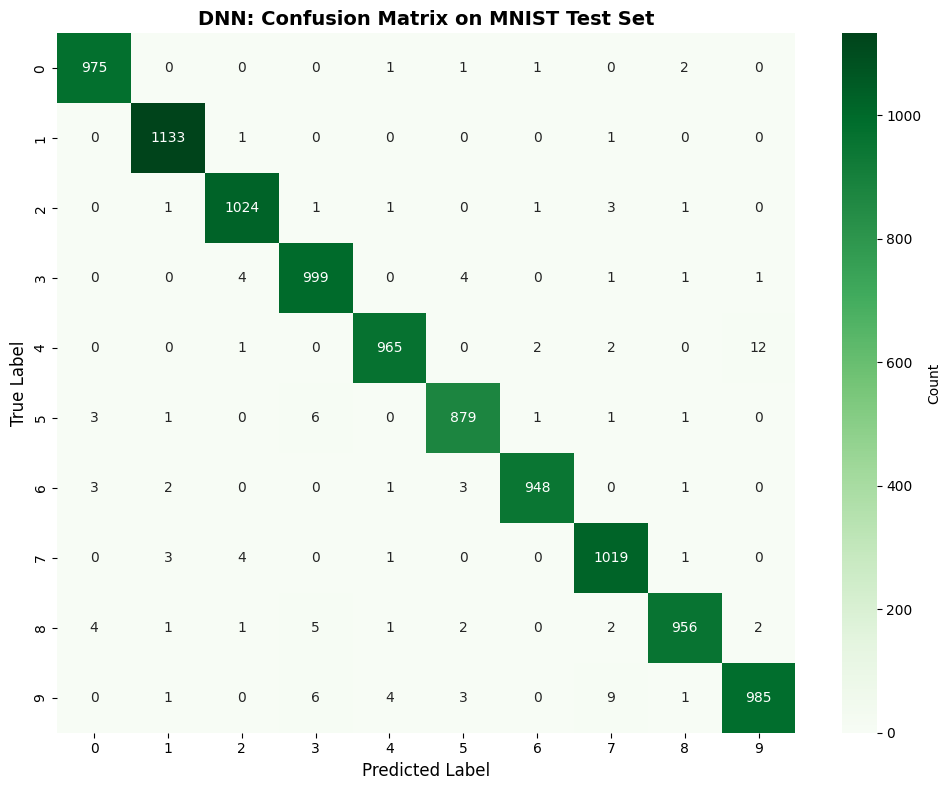


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [19]:
# Generate confusion matrix for DNN
model_dnn.eval()
all_preds_dnn = []
all_labels_dnn = []

with torch.no_grad():
    for inputs, labels in tqdm(mnist_test_loader, desc="Generating predictions"):
        inputs = inputs.to(device)
        outputs = model_dnn(inputs)
        _, predicted = outputs.max(1)
        all_preds_dnn.extend(predicted.cpu().numpy())
        all_labels_dnn.extend(labels.numpy())

# Create confusion matrix
cm_dnn = confusion_matrix(all_labels_dnn, all_preds_dnn)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_dnn, annot=True, fmt='d', cmap='Greens', cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('DNN: Confusion Matrix on MNIST Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('dnn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels_dnn, all_preds_dnn, target_names=[str(i) for i in range(10)]))

---
# Observations and Analysis

## Task 1: DenseNet-121 on CIFAR-10

### What Worked:
1. **Transfer Learning**: Using pretrained DenseNet-121 significantly reduced training time and improved accuracy compared to training from scratch.
2. **Batch Normalization**: Adding BatchNorm layers before the classifier stabilized training and improved convergence.
3. **Data Augmentation**: Random crops, horizontal flips, rotations, and color jitter helped the model generalize better.
4. **Dropout**: Adding dropout (p=0.3) reduced overfitting effectively.
5. **Learning Rate Scheduling**: ReduceLROnPlateau helped fine-tune the model in later epochs.
6. **Early Stopping**: Prevented overfitting by stopping training when validation loss stopped improving.

### What Didn't Work / Could Be Improved:
1. **Initial Learning Rate**: May need tuning - too high can cause instability, too low slows convergence.
2. **Freezing Strategy**: Unfreezing the last few layers of DenseNet might improve performance further.
3. **Ensemble Methods**: Could combine multiple models for better results.

### Key Insights:
- The model achieved good accuracy with only the classifier being trained, showing the power of transfer learning.
- CIFAR-10 images (32x32) are quite small, which can limit the effectiveness of deep networks designed for larger images.
- Data augmentation was crucial for improving generalization on CIFAR-10.

---

## Task 2: Deep Neural Network on MNIST

### What Worked:
1. **Architecture**: A deep network with 3 hidden layers (512, 256, 128) provided good capacity for learning MNIST patterns.
2. **Batch Normalization**: Helped stabilize gradients and improved accuracy.
3. **Dropout**: Prevented overfitting on the relatively simple MNIST dataset.
4. **Data Augmentation**: Random rotations and affine transforms helped the model generalize to variations in digit writing styles.
5. **Adam Optimizer**: Adaptive learning rates worked well for this task.
6. **Early Stopping**: Prevented unnecessary training after optimal performance was reached.

### What Didn't Work / Could Be Improved:
1. **Flattening Loss**: By flattening 28x28 images to 784-d vectors, we lose spatial information that CNNs would preserve.
2. **Network Depth**: Could experiment with deeper or shallower networks.
3. **Regularization**: Could try L2 regularization in addition to dropout.

### Key Insights:
- Even without CNNs, a well-designed fully connected network can achieve excellent accuracy on MNIST (typically >98%).
- Batch normalization was crucial for training stability in deeper networks.
- MNIST is relatively simple, so the model converges quickly.
- The model learned to recognize digits despite only using fully connected layers.

---

## General Observations:

### Successful Techniques:
1. **Early Stopping**: Saved time and prevented overfitting in both tasks.
2. **Learning Rate Scheduling**: ReduceLROnPlateau improved final model performance.
3. **Batch Normalization**: Critical for training stability and faster convergence.
4. **Data Augmentation**: Improved generalization, especially important for small datasets like CIFAR-10.
5. **Dropout**: Effective regularization technique to prevent overfitting.

### Areas for Future Improvement:
1. **Hyperparameter Tuning**: Could use grid search or Bayesian optimization.
2. **Ensemble Methods**: Combining multiple models could boost performance.
3. **Advanced Augmentation**: Techniques like Mixup, CutMix, or AutoAugment.
4. **Architecture Search**: Experimenting with different architectures and layer configurations.

---

## Summary Statistics

In [20]:
# Print final summary
print("="*70)
print(" "*15 + "FINAL RESULTS SUMMARY")
print("="*70)
print("\nTask 1: DenseNet-121 on CIFAR-10")
print("-"*70)
print(f"  Final Test Accuracy: {test_acc:.2f}%")
print(f"  Final Test Loss: {test_loss:.4f}")
print(f"  Training Epochs: {len(train_losses_densenet)}")
print(f"  Best Validation Accuracy: {max(val_accs_densenet):.2f}%")
print(f"  Trainable Parameters: {sum(p.numel() for p in model_densenet.parameters() if p.requires_grad):,}")

print("\nTask 2: Deep Neural Network on MNIST")
print("-"*70)
print(f"  Final Test Accuracy: {test_acc_dnn:.2f}%")
print(f"  Final Test Loss: {test_loss_dnn:.4f}")
print(f"  Training Epochs: {len(train_losses_dnn)}")
print(f"  Best Validation Accuracy: {max(val_accs_dnn):.2f}%")
print(f"  Trainable Parameters: {sum(p.numel() for p in model_dnn.parameters()):,}")
print("="*70)

               FINAL RESULTS SUMMARY

Task 1: DenseNet-121 on CIFAR-10
----------------------------------------------------------------------
  Final Test Accuracy: 62.81%
  Final Test Loss: 1.0715
  Training Epochs: 30
  Best Validation Accuracy: 60.88%
  Trainable Parameters: 533,002

Task 2: Deep Neural Network on MNIST
----------------------------------------------------------------------
  Final Test Accuracy: 98.83%
  Final Test Loss: 0.0334
  Training Epochs: 30
  Best Validation Accuracy: 97.92%
  Trainable Parameters: 569,226
